# Pytorch Image Models (timm)

该教程主要内容源自 ：[Getting Started with PyTorch Image Models (timm): A Practitioner’s Guide](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055)

timm 是 Ross Wightman 创建的深度学习库，是一个大型集合，包括了SOTA计算机视觉模型、神经网络层、实用函数、优化器、调度器、数据加载器、数据增强器以及训练/验证脚本等。

我们可以用`pip`来安装 `timm`：`pip install timm`。


总结一下 timm 的主要功能：

1. 主流的视觉相关的模型的代码实现，以及预训练权重，模型是纯 pytorch 写的，非常简洁，没有冗余的包装与抽象
2. timm 里的模型可以作为一个很好的特征抽取器，我们可以作为我们下游任务的 backbone，进行微调或接一些其他的任务头。
3. timm 在 torchvision 之外，扩展提供了一些比较新、比较复杂的图像增强的功能，比如 randaugment, cutmix,mixup 等。
4. timm 在 数据集获取上做了一定的扩展，我们可以更方便的拉取 torchvision 中的数据集，同时也可以读取本地数据集，支持的 parser 更多。
5. timm 在 pytorch 基本上扩展了一些新的 optimizer 的实现，扩展了一些学习率调度器的实现。

# 1. 模型

timm 最受欢迎的功能之一是其庞大且不断增长的模型架构集合。其中大部分模型包含预训练的权重 —— 这些权重要么是在 PyTorch 中原生训练的，要么是从 Jax 和 TensorFlow 等其他库中移植的 —— 可以轻松下载和使用。

## 1.1 列出可用的模型

In [1]:
import timm

# 列出所有可用的模型架构
all_models = timm.list_models()

# 列出所有带预训练权重的模型
all_pretrained_models = timm.list_models(pretrained=True)

# 使用通配符进行模糊查找
all_resnet_models = timm.list_models("resnet*")

timm 中有几百个模型，且该数字还在不断增长，如果你觉得选择困难的话，可以参考 Papers with code上 的 [总结页](https://paperswithcode.com/lib/timm)，它包含了 timm 中许多模型的基准和原始论文的链接。 也可以在 HuggingFace 的文档页面看到支持的 [🤗 Model Summary](https://huggingface.co/docs/timm/models)

## 1.2 创建模型

使用timm创建模型非常简单。`create_model` 是一个用来可以创建超过300个模型的工厂函数。我们也可以选择创建一个预训练模型，仅需额外传递一个参数。

In [2]:
model = timm.create_model("resnet34")
pretrain_model = timm.create_model("resnet34", pretrained=True)

为了进一步了解如何使用这个模型，可以通过 `default_cfg` 访问它的配置。其中包含的信息有：应该用来归一化输入数据的统计数据 `mean` 和 `std`、输出类别的数目 `num_classe`s和网络中分类器的名称 `classifier` 等信息。

In [3]:
model.default_cfg

{'url': 'https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet34_a1_0-46f8f793.pth',
 'hf_hub_id': 'timm/resnet34.a1_in1k',
 'architecture': 'resnet34',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

## 1.2 创建可变输入通道数目的模型

timm模型有一个不太为人所知、但却非常有用的特点，那就是它们能够处理具有不同通道数的输入图像，这对大多数其他库来说都是一个问题；这里给出了一个关于这个工作原理的大致解释。直观地说，timm通过对少于3个通道的初始卷积层的权重进行求和，或者智能地将这些权重复制到所需的通道数上，来实现这一目的。

值得注意的是，虽然这使我们能够使用一个预训练的模型，但输入的图像与模型训练所基于的图像有很大的不同。正因为如此，我们不应该期待同样的性能水平，在将模型用于任务之前，应该在新的数据集上对其进行微调。

In [4]:
model_1_chans = timm.create_model("resnet34", pretrained=True, in_chans=1)

In [5]:
import torch

print(model_1_chans.conv1.weight.shape)

torch.allclose(
    pretrain_model.conv1.weight.sum(dim=1, keepdim=True), model_1_chans.conv1.weight
)

torch.Size([64, 1, 7, 7])


True

通过检查第一个卷积层的参数的形状，我们可以发现，它的输入通道数变成了 `1`，经过我们的验证，新的 conv1 的参数就是原来 3 通道的 conv1 的权重加和的结果。

## 1.3 对默认的模型进行定制化

除了用现有架构创建模型外，create_model还支持一些参数，使我们能够为特定的任务定制一个模型。不过需要注意的是，支持的参数可能取决于底层的模型架构。

* 一些参数，如 `global_pool` 就是与具体模型相关，该参会决定全局池化的类型，它在 ResNet-like 的模型中是有效的，但就不适用于比如 ViT 这样的模型，因为 ViT 不使用平均池化。
* 另一些参数，如丢弃率 `drop_rate` 和输出类别数 `num_classes` 就适用于大多数模型。

所以提前查看当前模型的默认架构是非常有必要的。

### 1.3.1 改变输出类别数量

由上面的模型配置可以看出，网络的分类器名字是 `fc`。可以用它来直接访问相应的模块：

In [6]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

然而，这个名字很可能会根据使用的模型架构而改变。为了给不同的模型提供一个一致的接口，timm 模型有 `get_classifier` 方法，我们可以用它来获得分类器，而不需要查询模块名称：

In [7]:
model.get_classifier()

Linear(in_features=512, out_features=1000, bias=True)

由于这个模型是在 ImageNet 上预训练的，我们可以看到最后一层输出 1000 个类。可以通过 `num_classes` 参数来改变这一点。

In [8]:
# 创建一个自定义类别数目的模型，仅需额外传递一个参数
model = timm.create_model("resnet34", num_classes=10)
model.get_classifier()

Linear(in_features=512, out_features=10, bias=True)

此时查看该模型的分类器，可以看到，timm已经用一个新的、未经训练的、具有所需类别数的线性层替换了最后一层；然后就可以在自己的数据集上进行微调。

如果想完全避免创建最后一层，可以将类的数量设置为0，这将创建一个以 `Identity()` 恒等函数为最后一层的模型；这对检查倒数第二层的输出很有用。

In [9]:
model = timm.create_model("resnet34", num_classes=0)
model.get_classifier()

Identity()

### 1.3.2 修饰池化层的类型

所有 `timm` 模型的池化层都使用了一个 `SelectAdaptivePool2d` 类型的自定义池化层实现，支持不同的池化和压平配置：

* `avg` 平均池化
* `max` 最大池化
* `avgmax` 平均池化和最大池化的和，然后 0.5 倍的缩放
* `catavgmax` 沿着特征维度将平均池化和最大池化的输出连接起来。注意，这将使特征维度增加一倍
* `''` 不使用池化，池化层变成一个恒等函数替代

In [10]:
model.global_pool

SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))

通过以下代码查看一下不同池化选项的效果

In [11]:
pool_types = ["avg", "max", "avgmax", "catavgmax", ""]

for pool in pool_types:
    model = timm.create_model(
        "resnet34", pretrained=True, num_classes=0, global_pool=pool
    )
    model.eval()
    feature_output = model(torch.randn(1, 3, 224, 224))
    print(f"pool types: {pool}, feature map shape: {feature_output.shape}")

pool types: avg, feature map shape: torch.Size([1, 512])
pool types: max, feature map shape: torch.Size([1, 512])
pool types: avgmax, feature map shape: torch.Size([1, 512])
pool types: catavgmax, feature map shape: torch.Size([1, 1024])
pool types: , feature map shape: torch.Size([1, 512, 7, 7])


### 1.33 创建新的分类器

虽然已经证明使用单一的线性层作为分类器足以取得良好的效果，但在下游任务上微调模型时，Chris Hughes发现使用一个稍大的头可以导致性能的提高。

接下来探讨一下如何进一步修改之前的ResNet模型。

首先，以前一样创建 ResNet 模型，指定需要 10个 输出类别。由于使用的是一个较大的头，这里使用 catavgmax 来进行池化，这样就可以提供更多的信息作为分类器的输入。

In [12]:
model = timm.create_model(
    "resnet34", pretrained=True, num_classes=10, global_pool="catavgmax"
)

# 对于该模型的已有分类器，看一下它的输入特征
num_in_features = model.get_classifier().in_features
print(num_in_features)

1024


下面用一个自定义的分类器来直接替换原来的分类器：

In [13]:
import torch.nn as nn

model.fc = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(num_in_features, 512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(512, 10, bias=False),
)

model.eval()
model(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 10])

## 1.4 特征提取

timm 模型有一套统一的机制来获得各种类型的中间特征，这对于将一个架构作为下游任务的特征提取器是非常有用的。

In [14]:
model = timm.create_model("resnet34", pretrained=True)

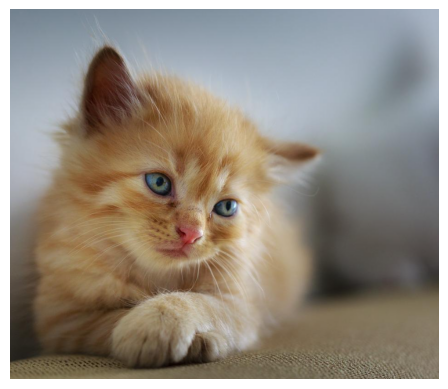

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

image = Image.open("../images/cat.png").convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.show()

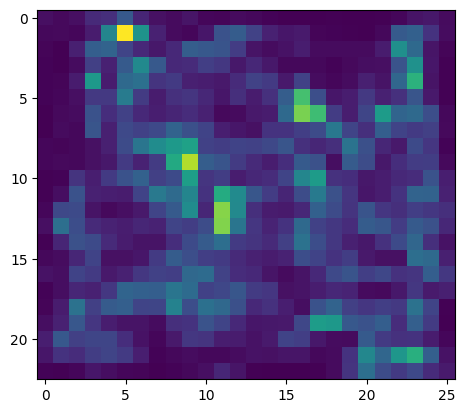

In [16]:
image = torch.as_tensor(np.array(image, dtype=np.float32)).transpose(2, 0)[None]
feature_output = model.forward_features(image)


def visualize_featrue_output(feat):
    plt.imshow(feat[0].transpose(0, 2).sum(-1).detach().numpy())


visualize_featrue_output(feature_output)

虽然forward_features方法可以方便地获得最终的特征图，但timm也提供了一些功能，使得可以将模型作为特征骨干，输出选定层次的特征图。

In [17]:
model.feature_info

[{'num_chs': 64, 'reduction': 2, 'module': 'act1'},
 {'num_chs': 64, 'reduction': 4, 'module': 'layer1'},
 {'num_chs': 128, 'reduction': 8, 'module': 'layer2'},
 {'num_chs': 256, 'reduction': 16, 'module': 'layer3'},
 {'num_chs': 512, 'reduction': 32, 'module': 'layer4'}]

实际上，在创建模型时，可以添加参数features_only=True来指定所使用模型作为特征骨干，即

In [18]:
model = timm.create_model("resnet34", pretrained=True, features_only=True)

此时生成的模型是FeatureListNet类型。如下所示，可以得到更多关于返回的特征的信息，如具体的模块名称，特征的减少量和通道的数量。默认情况下，大多数模型将输出5层（并非所有模型都有这么多步长），第一层从2开始（但有些从1或4开始）。

In [19]:
print(model.feature_info.module_name())
print(model.feature_info.reduction())
print(model.feature_info.channels())

['act1', 'layer1', 'layer2', 'layer3', 'layer4']
[2, 4, 8, 16, 32]
[64, 64, 128, 256, 512]


In [20]:
feature_maps = model(image)
for feature_map in feature_maps:
    print(feature_map.shape)

torch.Size([1, 64, 409, 353])
torch.Size([1, 64, 205, 177])
torch.Size([1, 128, 103, 89])
torch.Size([1, 256, 52, 45])
torch.Size([1, 512, 26, 23])


可以看出，能返回5个特征图，以及形状和通道数都符合预期。还可以具体可视化一下特征图：

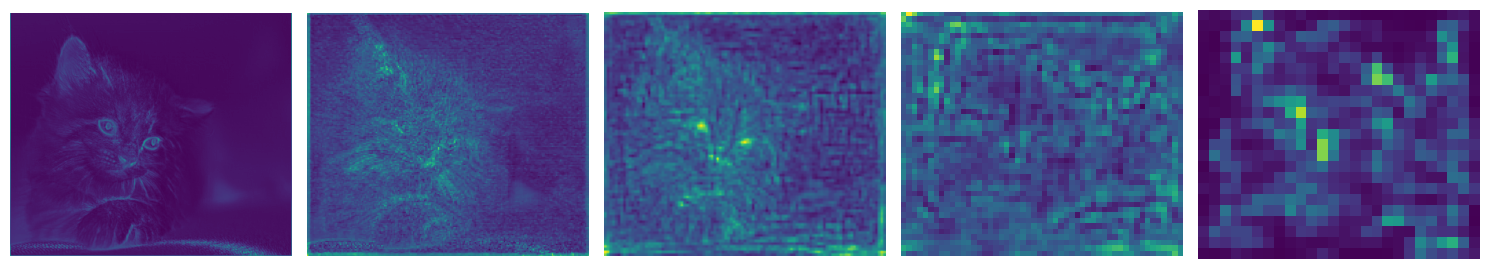

In [21]:
plt.figure(figsize=(15, 6))
for i, feature_map in enumerate(feature_maps):
    plt.subplot(1, 5, i + 1)
    plt.imshow(feature_map[0].transpose(0, 2).sum(-1).detach().numpy())
    plt.axis("off")

plt.tight_layout()
plt.show()

# 2. 数据增强


timm 提供了一些先进且高效的数据增强策略，不仅可以提升模型的泛化能力，还能够改善模型的鲁棒性。除了常见的剪裁、翻转等操作，它还包括了更为复杂和先进的技术：

* **RandAugment**：一种随机增强方法，类似于 AutoAugment，但更为简单高效。它随机选择不同的增强操作（如旋转、裁剪、亮度调整等）并应用在输入图像上。

* **Mixup & CutMix**：这两种增强技术是通过将两张图片混合在一起并混合其标签来增加样本的多样性。Mixup 是线性混合两张图像，CutMix 是在图像上随机裁剪出一块，并用另一张图片的相应区域替代。这两者对于提高模型的泛化能力，尤其是在小样本数据集上非常有效。

* **Random Erasing**：该方法随机在图片上擦除某个区域，以增强模型的鲁棒性，避免模型依赖图像某个局部特征。

这些高级数据增强方法广泛应用于比赛和实际应用中，能显著提升模型的性能。

In [22]:
from timm.data.transforms_factory import create_transform

create_transform(input_size=224)

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [23]:
create_transform(input_size=224, is_training=True)

Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

当设置 `is_training=True` 时，额外的转换，如水平翻转和颜色抖动，也包括在内。这些增强方式的数值大小可以通过参数 `hflip`、`vflip`和 `color_jitter` 来控制。

还可以看到，用于调整图像大小的方法也因是否是模型训练而不同。在验证期间使用标准的 `Resize` 和 `CenterCrop` ，而在训练期间则使用 `RandomResizedCropAndInterpolation`。

## RandAugment

当开始一个新的任务时，可能很难知道要使用哪些增强，以及以何种顺序使用；由于现在有大量的增强，组合的数量是巨大的。
通常，一个好的开始是使用一个在其他任务上表现出良好性能的增强管道。RandAugment就是这样一个策略，它是一种自动化的数据增强方法，从一组增强中统一采样操作——如均衡化、旋转、过曝、颜色抖动、海报化、改变对比度、改变亮度、改变锐度、剪切和平移——并按顺序应用其中的一些；更多信息请参见[原始论文](https://arxiv.org/abs/1909.13719)。

## CutMix

CutMix 是一种数据增强技术，它通过将两张图像的随机区域剪切并混合在一起，同时将其标签按比例混合来生成新的训练样本。它的核心思想是：

* 图像区域替换：从一张图像中随机剪切一个区域，并将其粘贴到另一张图像中。
* 标签混合：新的图像标签是根据被剪切区域的大小按比例混合的。例如，图像 A 的 70% 和图像 B 的 30% 构成了新的图像，那么标签也是 A 和 B 标签按 70% 和 30% 进行加权平均。

CutMix 它让模型学会处理图像的不同部分，有助于模型在复杂场景下识别目标。通过图像的随机剪切和混合，可以有效增加数据的多样性，降低模型的过拟合风险。


## Mixup

Mixup 是另一种基于图像和标签混合的增强技术。它通过将两张图像按一定比例进行线性插值，并对其对应的标签进行相同比例的线性插值，生成新的样本。它的做法如下：

* 图像混合：取两张图像 $x_1$ 和 $x_2$，按比例 $\lambda$ 生成新的图像 $x_{mix} = \lambda x_1 + (1-\lambda) x_2$
* 标签混合：对于新图像的标签 $y_{mix}$，使用相同的 $\lambda$ 进行插值，即：$y_{mix} = \lambda y_1 + (1-\lambda) y_2$

通过图像和标签的混合，模型会学习到更平滑的决策边界，这有助于提高分类任务中的准确性。另外，由于每个训练样本都是多个图像和标签的混合，模型对噪声数据点不再那么敏感，表现更加稳健。

# 3. 数据集

timm提供了许多有用的工具来处理不同类型的数据集。最简单的入门方法是使用create_dataset函数，它将为我们创建一个合适的数据集。

可以从本地文件夹加载数据，在这种情况下，只需使用一个空字符串（''）作为数据集名称。除了能够从ImageNet风格的文件夹层次中加载数据外，create_dataset还可以让我们从一个或多个tar档案中提取数据；可以用它来避免解开档案的麻烦。

# 4. 优化器

timm 集成了许多优化器，不仅包括常见的 Adam、SGD，还包含了一些在现代深度学习任务中表现优异的优化器。这些优化器针对不同的模型结构和任务进行了优化，特别适用于大规模图像分类任务：

* **AdamP**：这是 Adam 的一种变体，能够在优化过程中抑制参数的过拟合问题，特别适合那些容易导致模型过拟合的深层神经网络。

* **LAMB**：LAMB（Layer-wise Adaptive Moments optimization for Batch training）是一种在大批量训练时表现良好的优化器。它通过对每一层的权重进行自适应学习率调整，能够在不牺牲训练速度的情况下稳定模型的收敛。

* **RMSpropTF**：这是 TensorFlow 风格的 RMSprop 变体，添加了一个动量项。它在某些模型，尤其是像 MobileNetV3 这样的小模型上表现优异。

* **Adafactor**：适用于大规模训练，特别是在 Transformer 模型中常用。与 Adam 类似，但它能显著减少显存占用，使其适用于资源受限的环境。

# 5. 学习率调节器

timm 还集成了多种学习率调度策略，帮助优化模型的训练过程。学习率调度器对模型的最终性能至关重要，它们能够在训练过程中动态调整学习率，以提高模型的收敛速度，避免陷入局部最优解。

* **CosineAnnealingLR**：余弦退火调度器，通过逐渐减少学习率，使模型以较慢的学习率收敛到最优解，特别适合长时间的训练任务。

* **ExponentialLR**：指数衰减学习率，可以在训练过程中逐渐减小学习率，使模型收敛得更稳定。

* **OneCycleLR**：这种调度器先增大学习率，再逐渐减小，最终达到很小的学习率。它的设计目标是让模型在最后阶段以非常小的步长微调参数，从而更好地收敛。

* **StepLR**：每隔固定的 epoch（训练轮数），学习率按设定的步长下降。

* **ReduceLROnPlateau**：当监控的指标在一定的训练周期内不再改善时，动态降低学习率。这种调度器非常适合验证集表现停滞时使用。